# Explanining models

In [1]:
# Load the required packages
using SpeciesDistributionToolkit
using CairoMakie
using Statistics
CairoMakie.activate!(px_per_unit = 6.0)
import Random
Random.seed!(1234567)

Random.TaskLocalRNG()

In [2]:
# Get the polygon of interest
place = SpeciesDistributionToolkit.gadm("PRY")
extent = SpeciesDistributionToolkit.boundingbox(place)
provider = RasterData(CHELSA2, BioClim)
L = SDMLayer{Float16}[SDMLayer(provider; layer=l, extent...) for l in layers(provider)]
mask!(L, place);

In [3]:
# Get occurrence data from GBIF
tx = taxon("Akodon montensis")
presences = occurrences(tx, first(L), "occurrenceStatus" => "PRESENT", "country" => "PY", "limit" => 300, "hasCoordinate" => true)
occurrences!(presences)
println("Retrieved $(length(presences)) occurrences")

Retrieved 562 occurrences


In [4]:
# Pseudo-absence generation
presencelayer = mask(first(L), presences)
background = pseudoabsencemask(DistanceToEvent, presencelayer)
maskedbg = nodata(background, d -> d < 20)
bgpoints = backgroundpoints(maskedbg, 6sum(presencelayer))

SDM Layer with 479838 Bool cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

In [90]:
# Specification of the SDM
sdm = SDM(ZScore, Logistic, L, presencelayer, bgpoints)

ZScore → Logistic → P(x) ≥ 0.5

In [91]:
# Cross-validation
folds = kfold(sdm; k=15);
cv = crossvalidate(sdm, folds; threshold = true);
println("""
Validation: $(round(mcc(cv.validation); digits=2)) ± $(round(ci(cv.validation); digits=2))
Training: $(round(mcc(cv.training); digits=2)) ± $(round(ci(cv.training); digits=2))
""")

Validation: 0.88 ± 0.07
Training: 0.92 ± 0.0



In [92]:
forwardselection!(sdm, folds)
cv = crossvalidate(sdm, folds; threshold = true);
println("""
Validation: $(round(mcc(cv.validation); digits=2)) ± $(round(ci(cv.validation); digits=2))
Training: $(round(mcc(cv.training); digits=2)) ± $(round(ci(cv.training); digits=2))
""")

Validation: 0.89 ± 0.06
Training: 0.93 ± 0.01



In [93]:
train!(sdm)

ZScore → Logistic → P(x) ≥ 0.426

In [94]:
vi = variableimportance(sdm, folds; threshold=false)
vi ./= sum(vi)
vnames = ["BIO$(x)" for x in variables(sdm)]
varimp = sort(collect(zip(vnames, vi)), by=(x) -> last(x), rev=true)

5-element Vector{Tuple{String, Float64}}:
 ("BIO9", 0.42383278155820764)
 ("BIO14", 0.3004000773868276)
 ("BIO4", 0.13496088148775404)
 ("BIO5", 0.09260839285565876)
 ("BIO16", 0.04819786671155192)

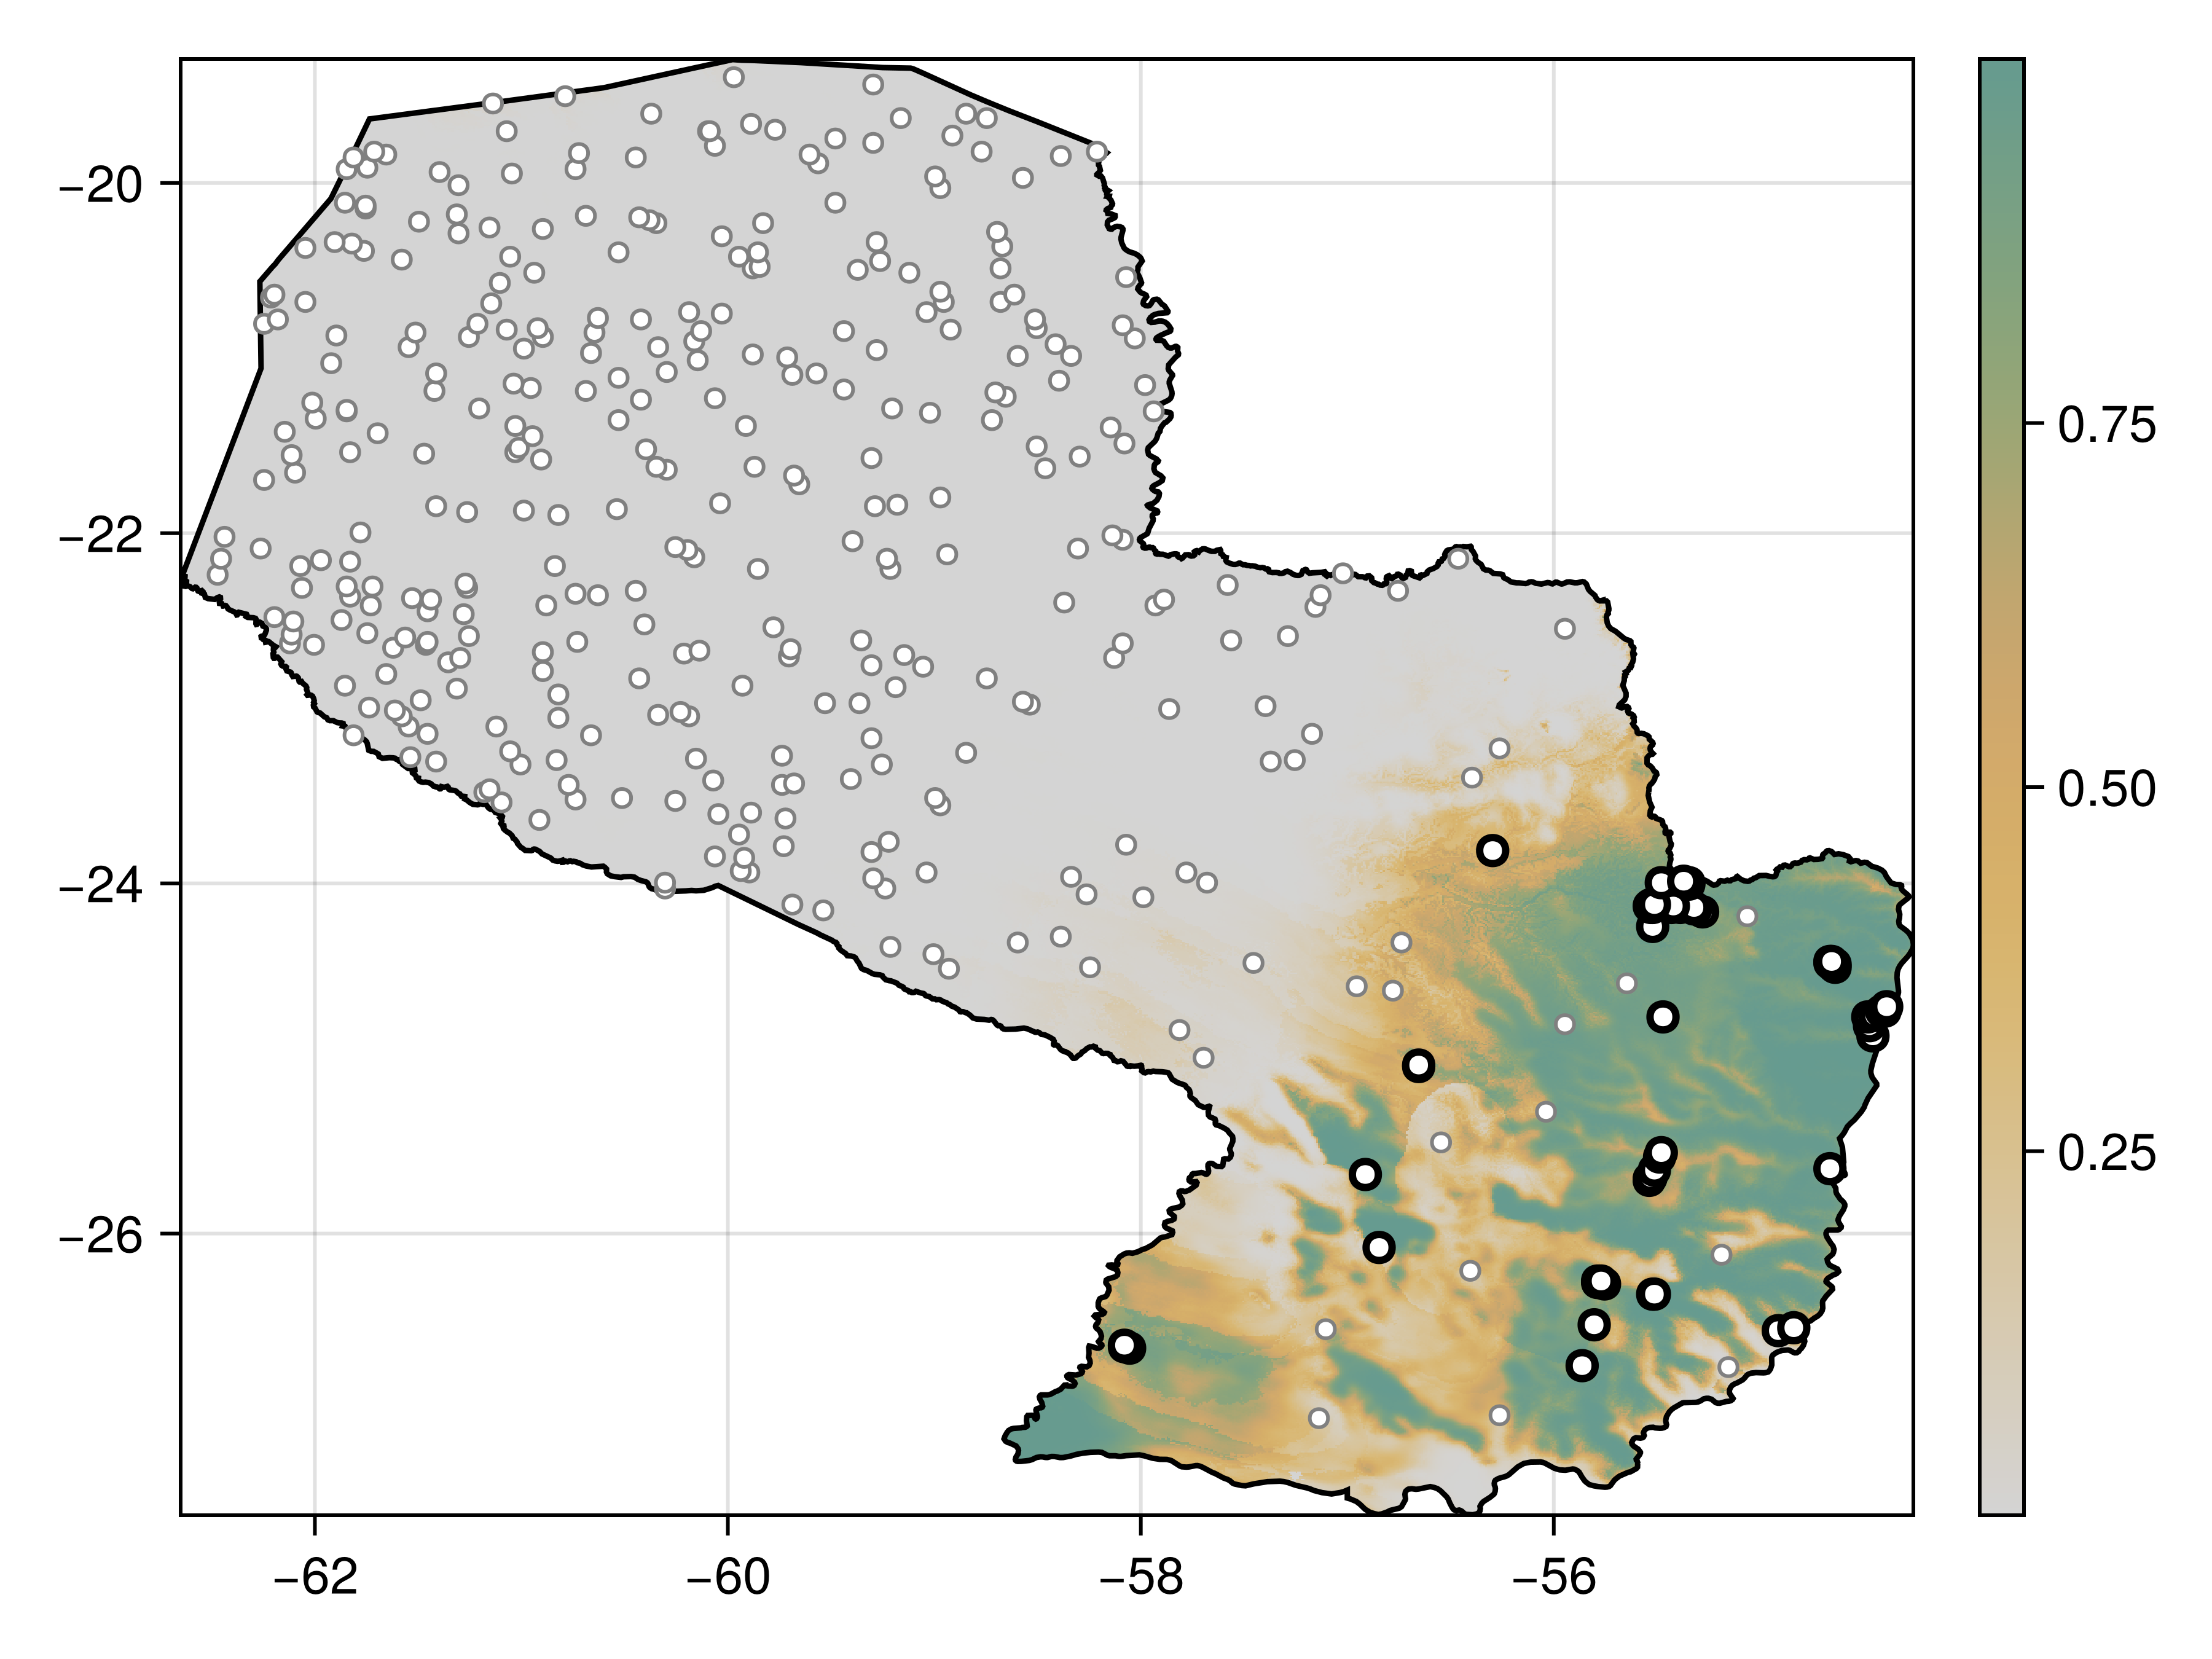

In [95]:
# Initial prediction (decision tree)
fg, ax, hm = heatmap(predict(sdm, L; threshold=false), colormap=Reverse(:linear_gow_60_85_c27_n256))
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
Colorbar(fg[1,2], hm)
fg

In [96]:
Si = explain(sdm, 9; threshold=false)

413-element Vector{Float64}:
  0.6808275774413852
  0.6667783088808856
  0.6832598312062977
  0.2705283634125031
  0.2507448595260319
  0.2464174221480132
  0.19394765790797736
  0.15285810271358902
  0.2412993465376596
  0.17243718237163097
  ⋮
  0.226408937198356
  0.06046561151081093
  0.22697696866980027
  0.2627673060954453
 -0.01689908039201117
  0.2178375641913735
  0.20720867565919068
  0.15693155841836964
  0.2140535930578677

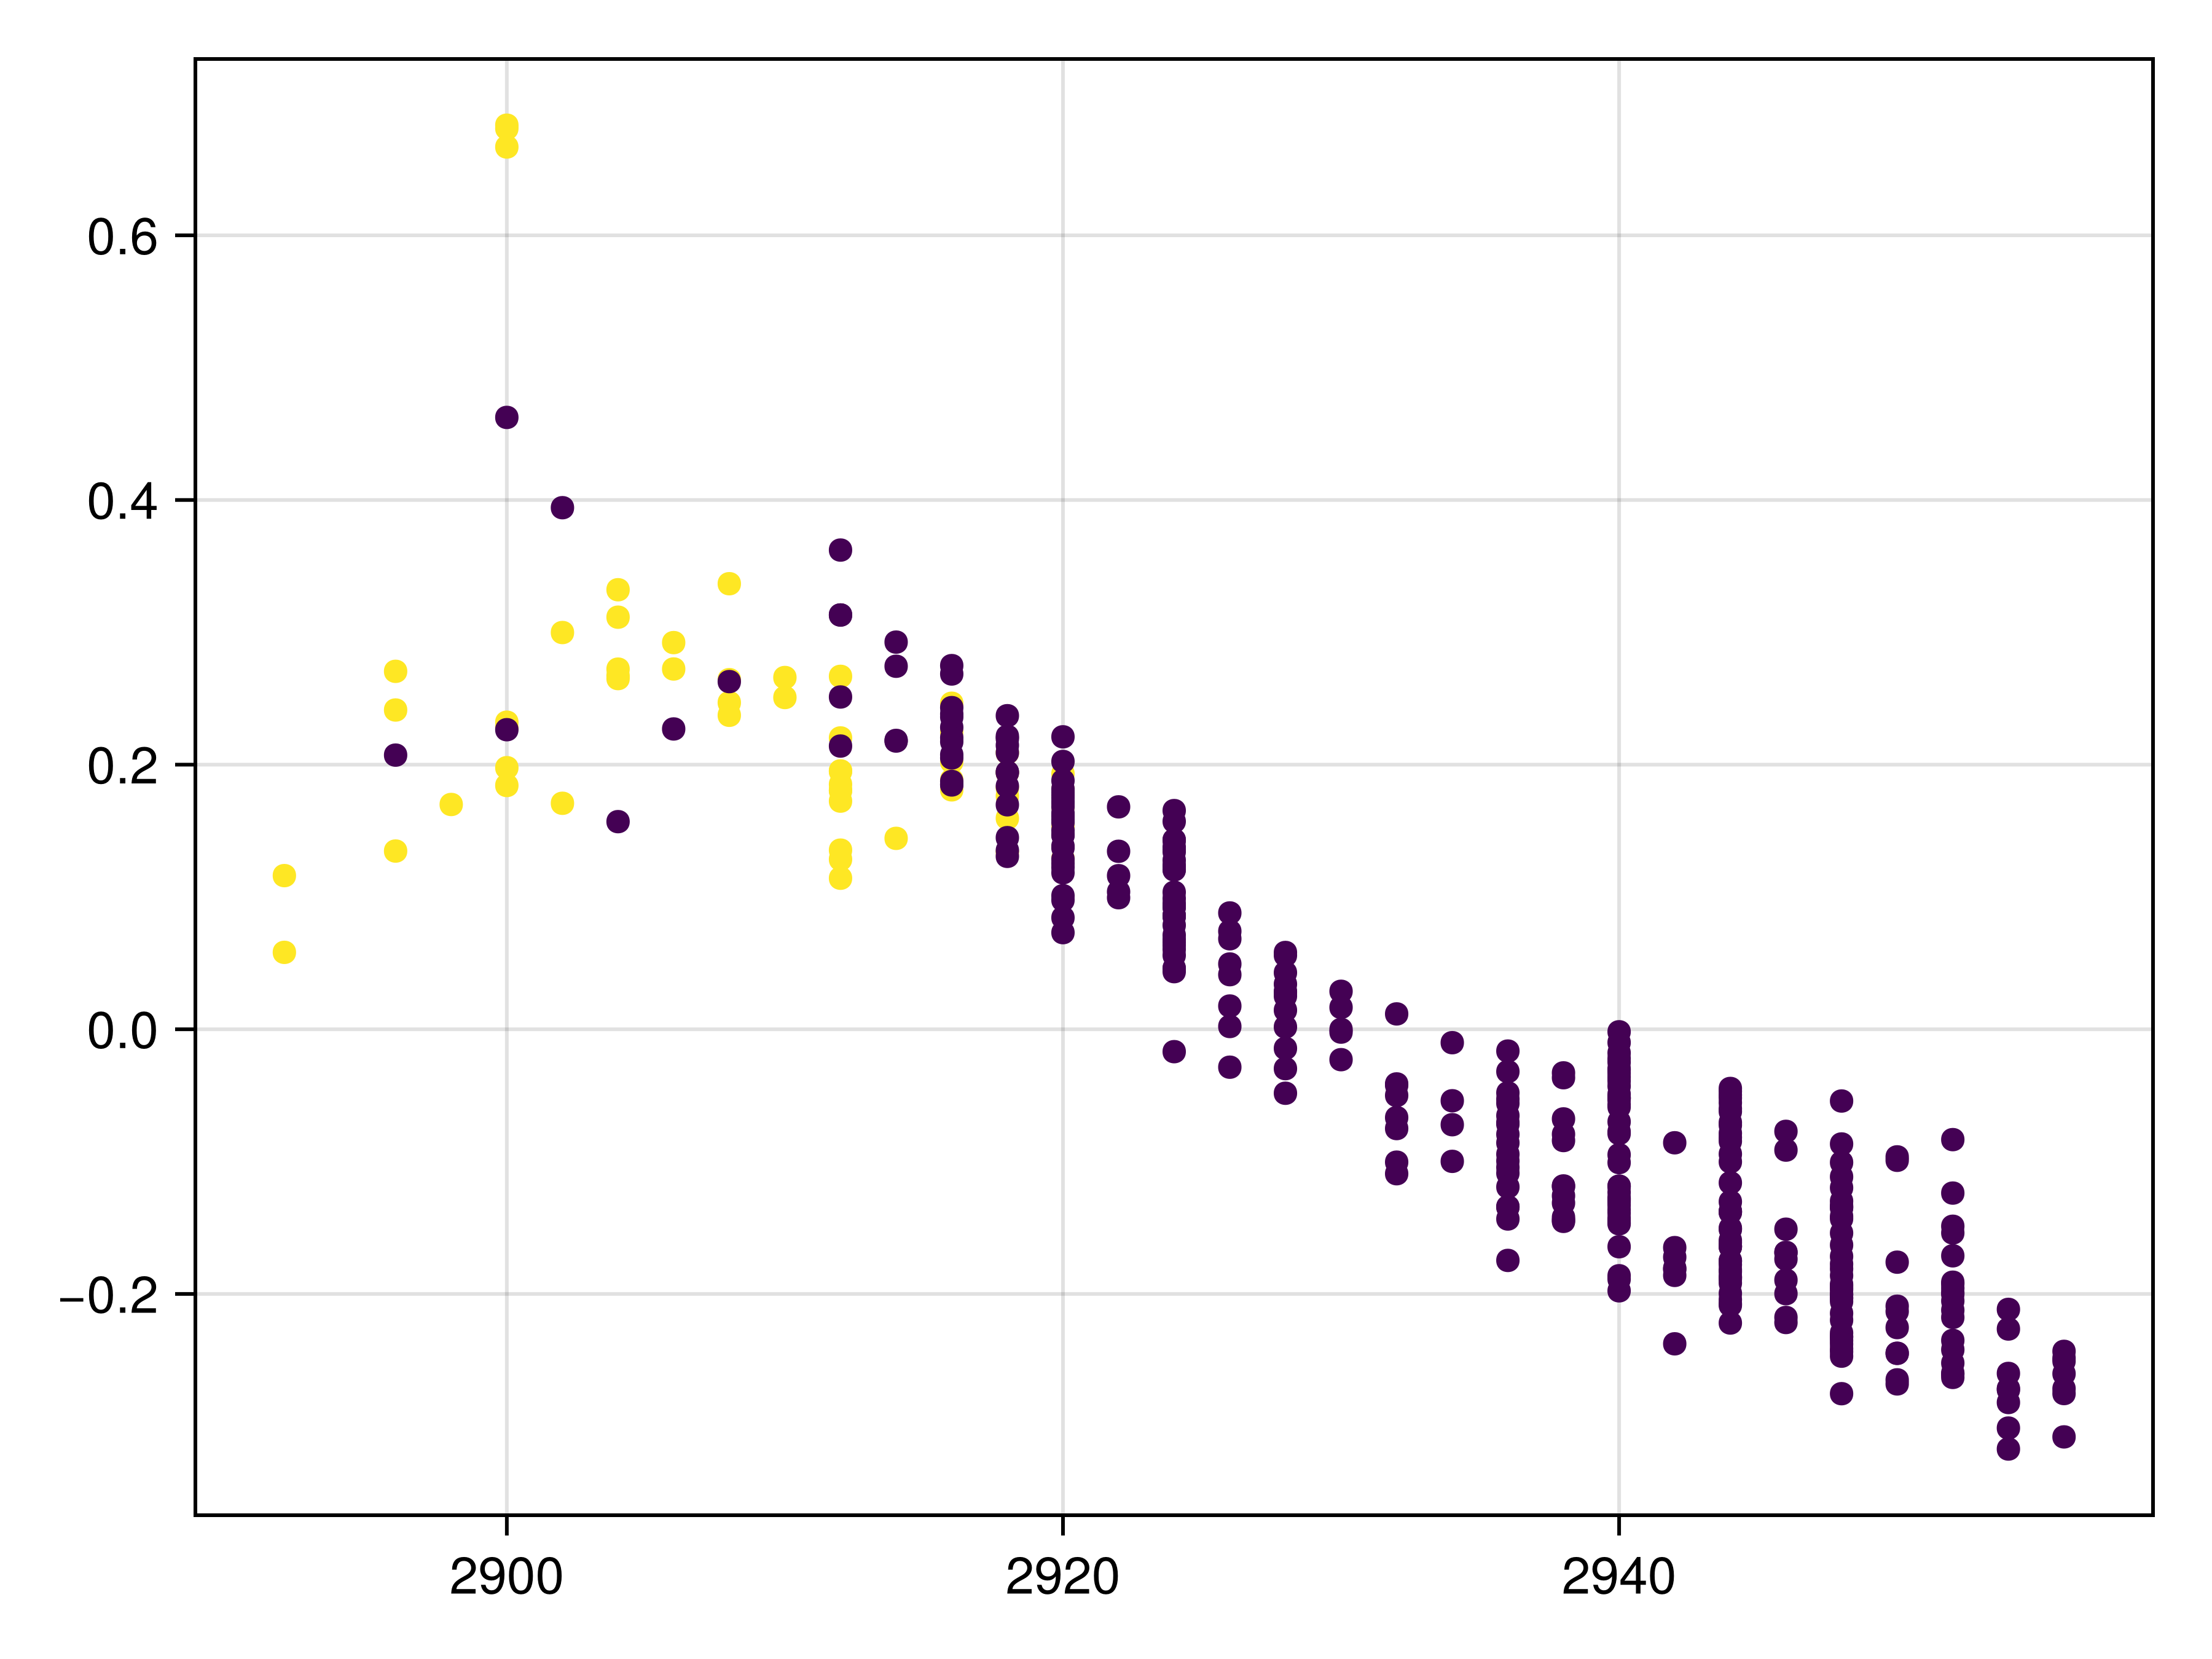

In [97]:
scatter(features(sdm, 9), Si, color=labels(sdm))

In [ ]:
Mi = explain(sdm, L, 9; threshold=false)

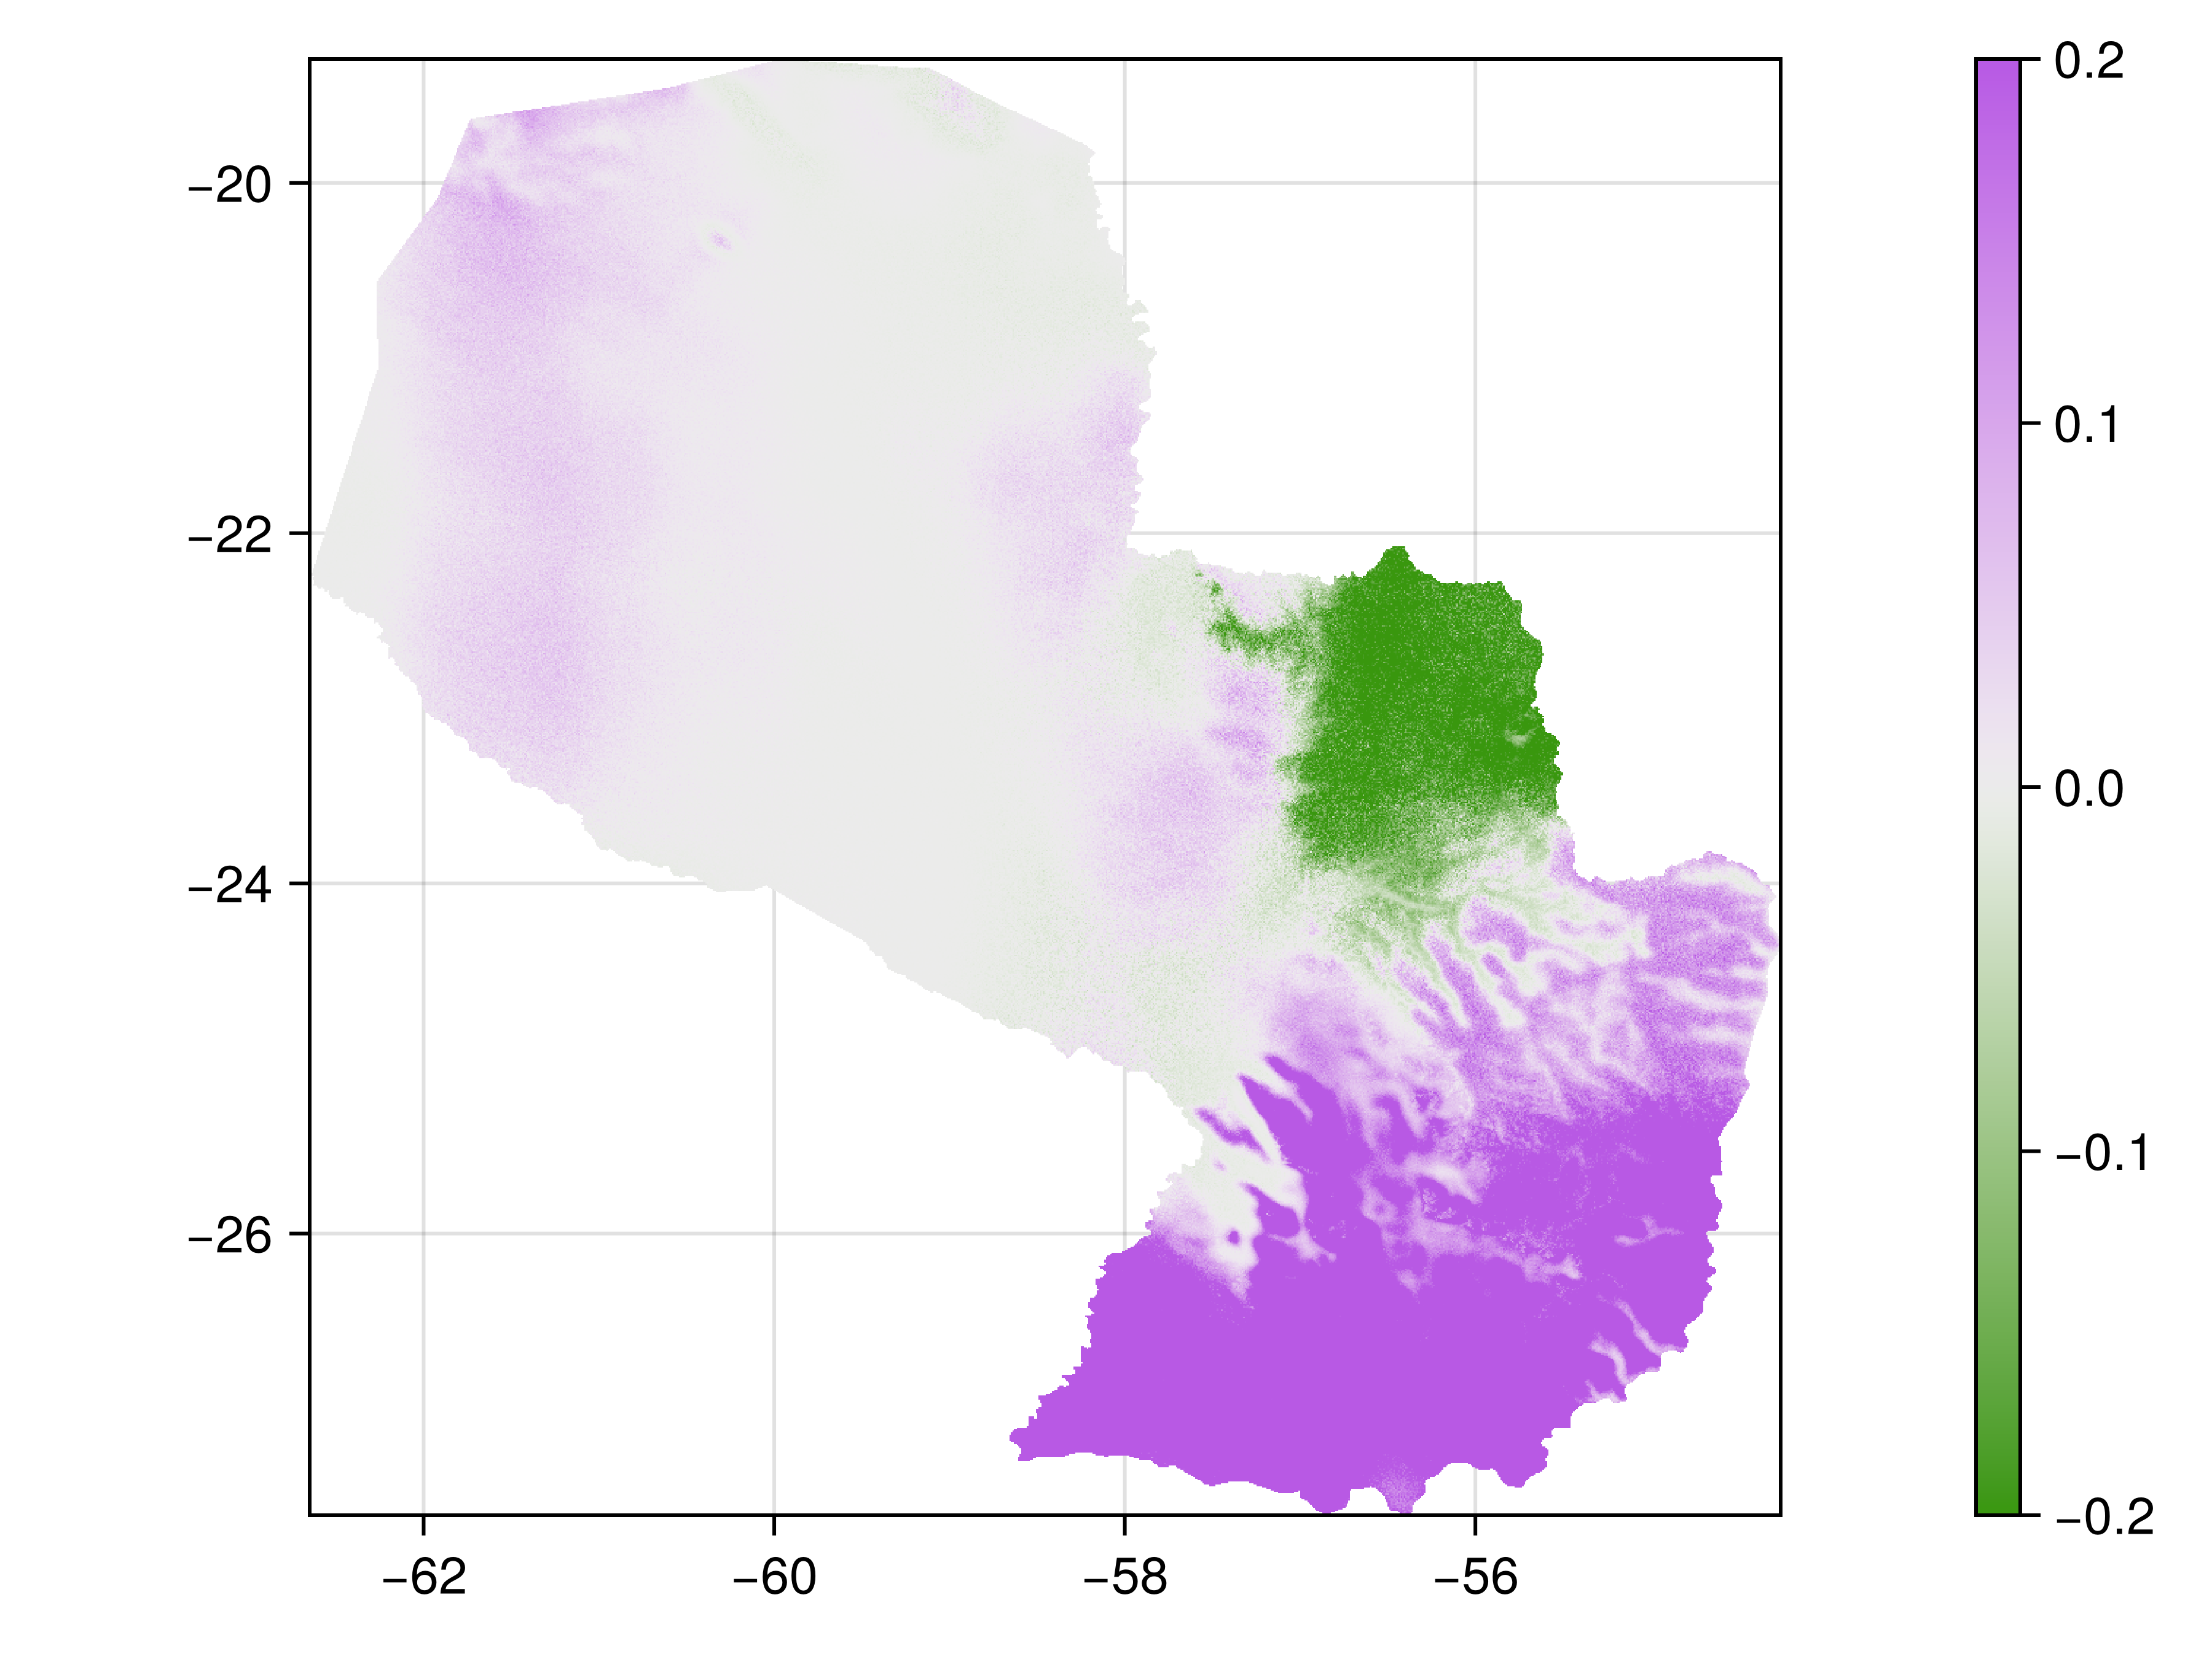

In [81]:
f = Figure()
ax = Axis(f[1,1], aspect=DataAspect())
hm = heatmap!(ax, Mi, colormap=:diverging_gwv_55_95_c39_n256, colorrange=(-0.2, 0.2))
Colorbar(f[1,2], hm)
f

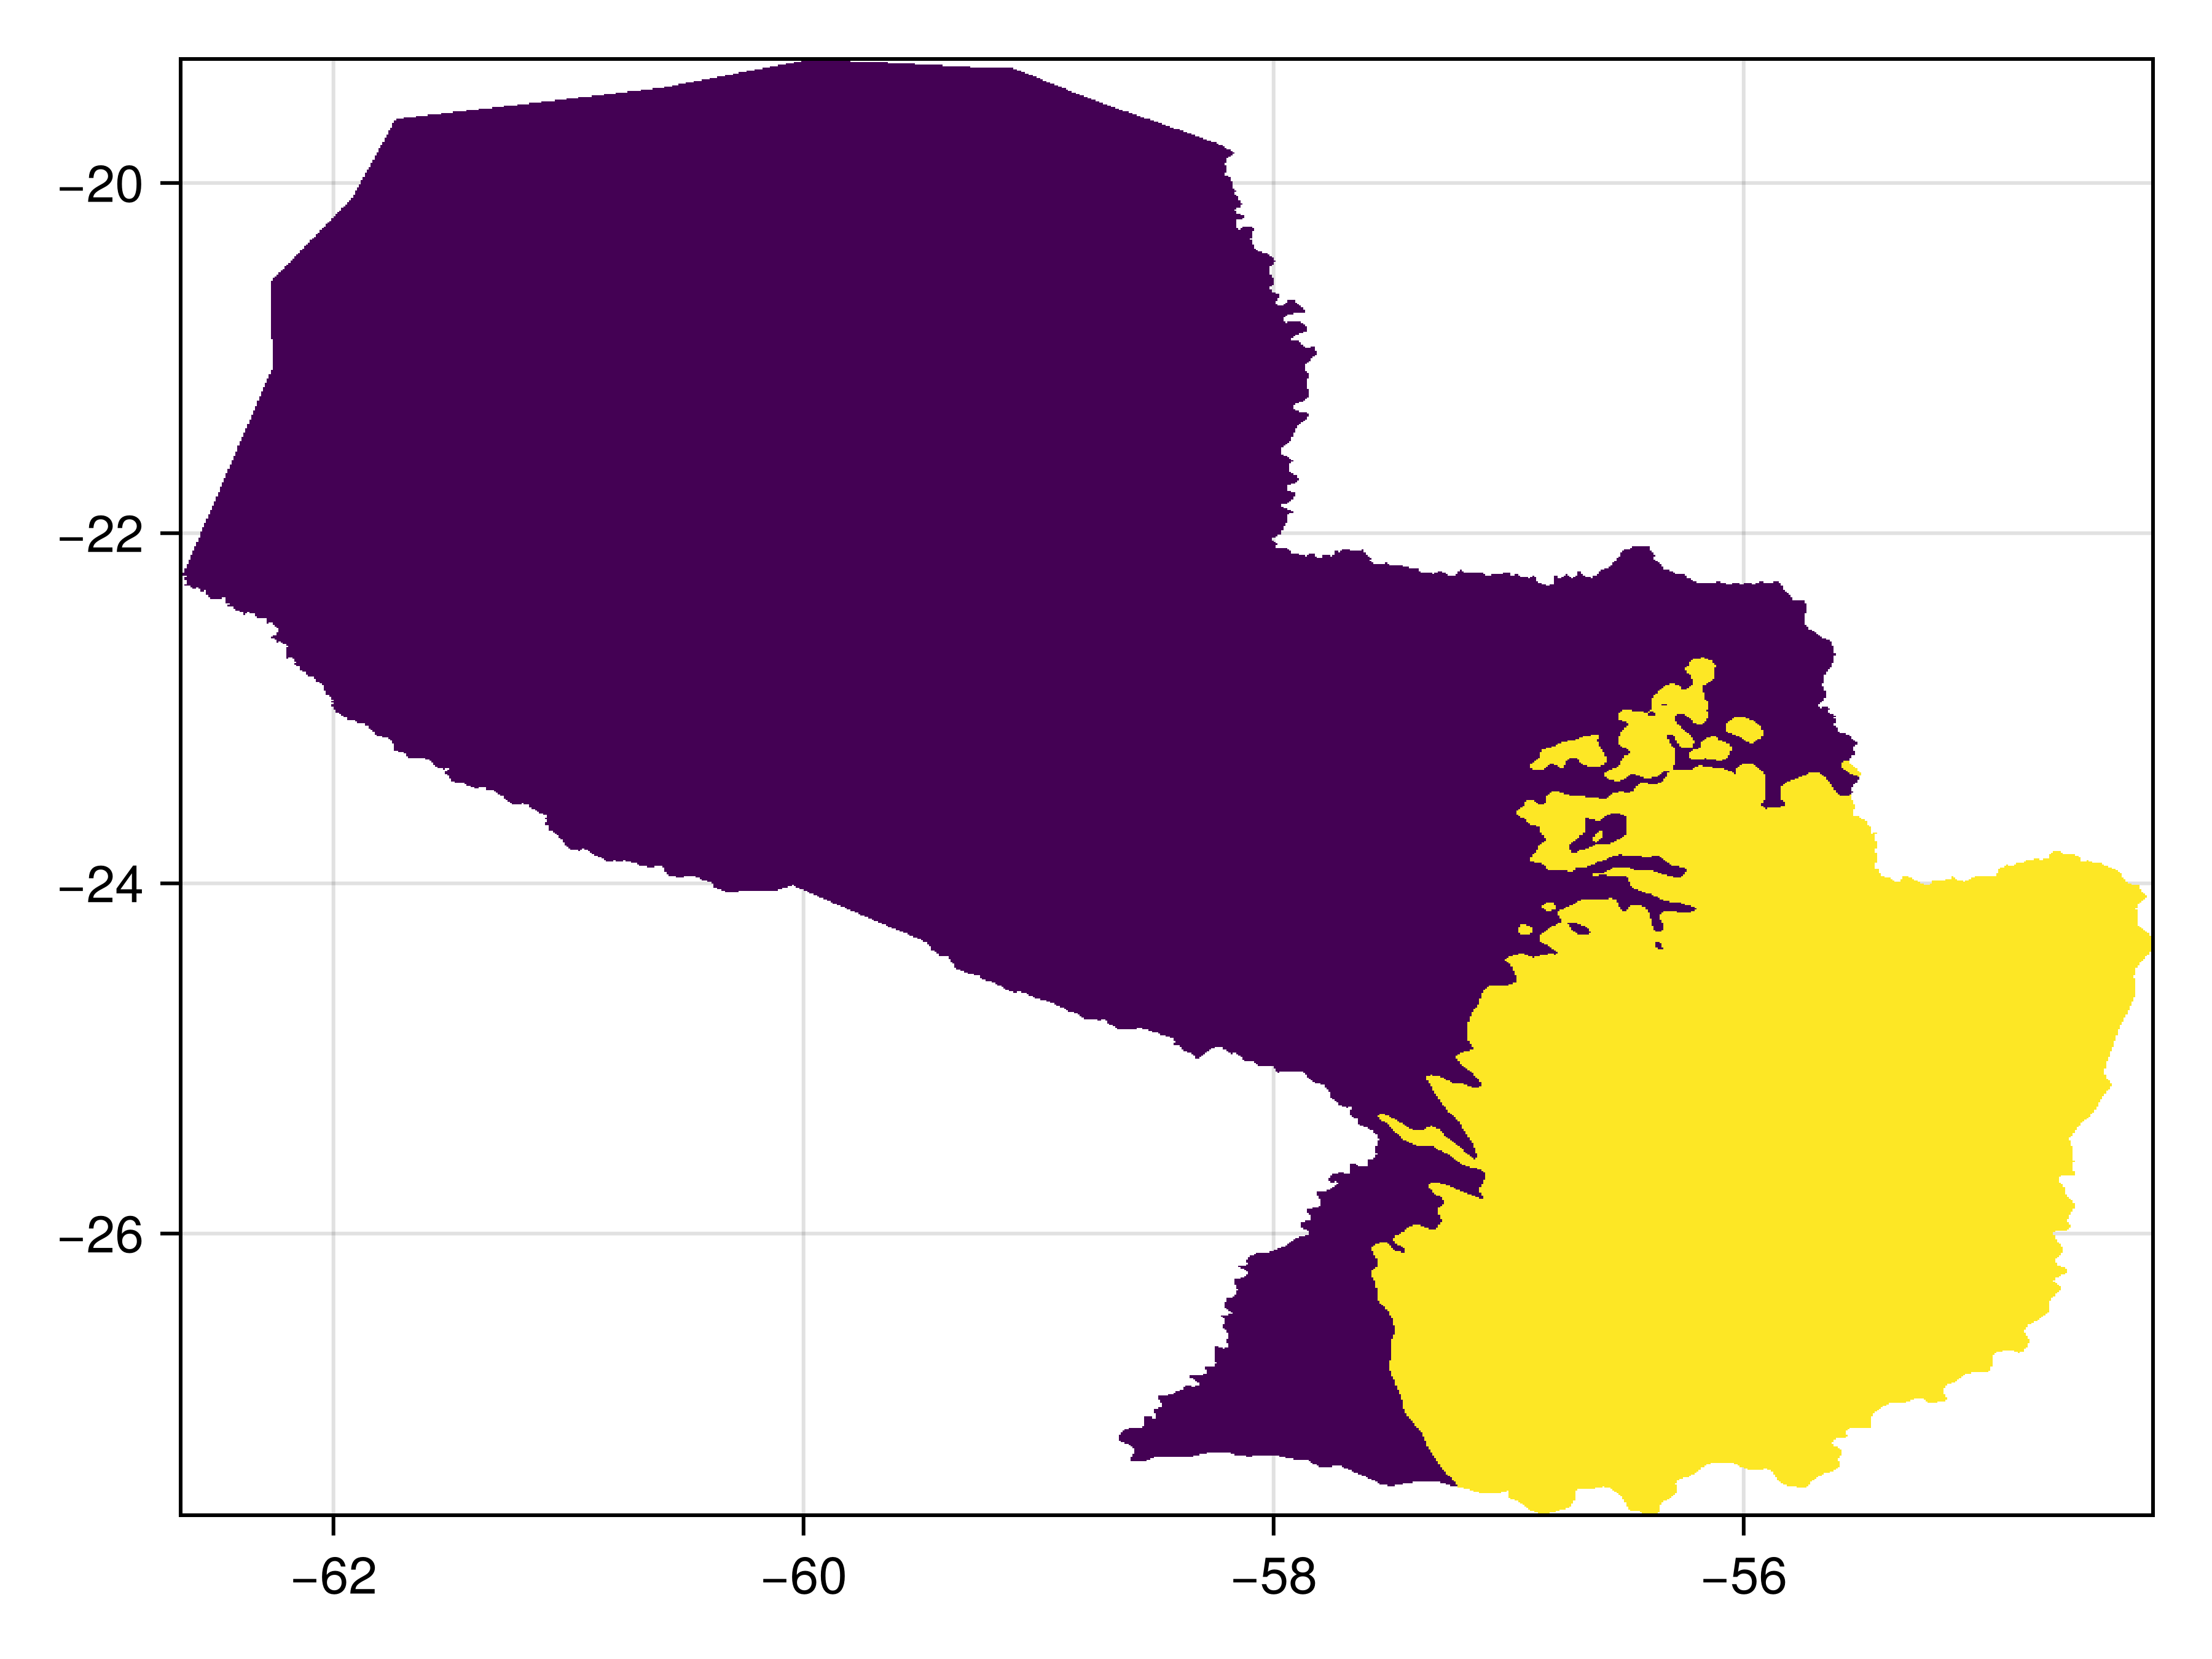

In [89]:
partialresponse(sdm, L, 14; threshold=true) |> heatmap